# Autoencoder Variacional en Generación de Imágenes
### Itzanami Berlanga Contreras | 12 de mayo del 2024

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32 

IMG_WIDTH  = 32 
IMG_HEIGHT = 32 

ENCODING_SIZE = 8 

directorio = "flowers"

# create a flower with labels generator
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  directorio,
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  directorio,
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  directorio,
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)

Found 15740 files belonging to 16 classes.
Found 15740 files.
Using 12592 files for training.
Found 15740 files.
Using 3148 files for validation.


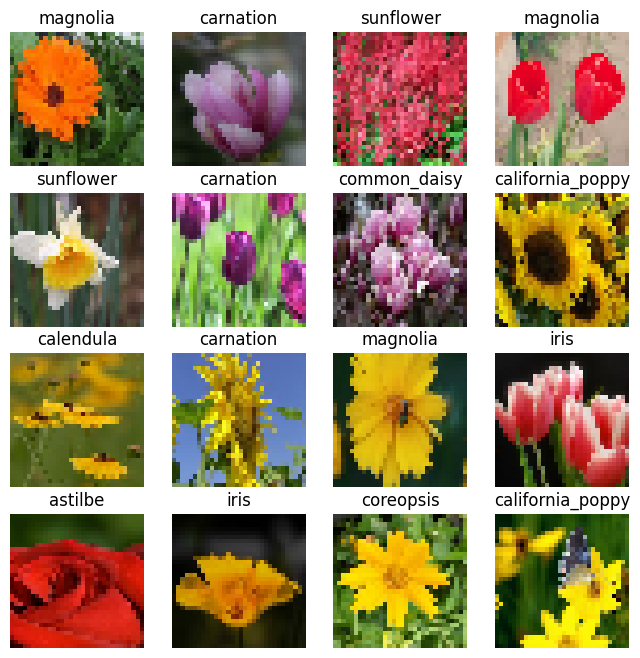

In [3]:
def plot_random_images(generator, class_names, num_images=16, grid_size=(4, 4)):
    plt.figure(figsize=(8, 8))
    for images, labels in generator.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()
    
plot_random_images(flower_generator, flower_names, num_images=16, grid_size=(4, 4))

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean_samp, z_log_var_samp = inputs
        batch = ops.shape(z_mean_samp)[0]
        dim = ops.shape(z_mean_samp)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean_samp + ops.exp(0.5 * z_log_var_samp) * epsilon

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = layers.Conv2D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'selu', kernel_initializer='lecun_normal')(encoder_inputs)
x = layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', activation = 'selu', kernel_initializer='lecun_normal')(x)
x = layers.Conv2D(256, kernel_size = 3, strides = 2, padding = 'same', activation = 'selu', kernel_initializer='lecun_normal')(x)
x = layers.Conv2D(512, kernel_size = 3, strides = 2, padding = 'same', activation = 'selu', kernel_initializer='lecun_normal')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     73,856 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │     16,386 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │     16,386 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,583,748 (6.04 MB)

 Trainable params: 1,583,748 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512 * 4 * 4, activation = "selu")(latent_inputs)
x = layers.Reshape([4, 4, 512])(x)
x = layers.Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1, padding = "same", activation = "selu")(x)
x = layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2, padding = "same", activation = "selu")(x)
x = layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, padding = "same", activation = "selu")(x)
x = layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = "same", activation = "selu")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,934,851 (15.01 MB)

 Trainable params: 3,934,851 (15.01 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
K = keras.backend

_, _, codings = encoder(encoder_inputs)
reconstructions = decoder(codings)
vae = keras.Model(inputs = [encoder_inputs], outputs = [reconstructions], name="VAE")

vae.summary()

# add a loss function
latent_loss = -0.5 * ops.sum(1 + z_log_var - ops.exp(z_log_var) - ops.square(z_mean), axis = -1)
vae.add_loss(ops.mean(latent_loss))

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 2), (None, 2), │     1,583,748 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │     3,934,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,518,599 (21.05 MB)

 Trainable params: 5,518,599 (21.05 MB)

 Non-trainable params: 0 (0.00 B)

NotImplementedError: 

In [15]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            print(data)
            z_mean_ts, z_log_var_ts, z_ts = self.encoder(data)
            reconstruction = self.decoder(z_ts)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var_ts - ops.square(z_mean_ts) - ops.exp(z_log_var_ts))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(training_generator,  epochs = 30) #, callbacks = [lr_scheduler, early_stopping_cb]

Epoch 1/30
Tensor("data:0", shape=(None, 32, 32, 3), dtype=float32)
Tensor("data:0", shape=(None, 32, 32, 3), dtype=float32)
 83/394 ━━━━━━━━━━━━━━━━━━━━ 2:14 434ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan

KeyboardInterrupt: 

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of flowers
    flower_size = 32
    scale = 1.0
    figure = np.zeros((flower_size * n, flower_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of flower classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            flower = x_decoded[0].reshape(flower_size, flower_size)
            figure[
                i * flower_size : (i + 1) * flower_size,
                j * flower_size : (j + 1) * flower_size,
            ] = flower

    plt.figure(figsize=(figsize, figsize))
    start_range = flower_size // 2
    end_range = n * flower_size + start_range
    pixel_range = np.arange(start_range, end_range, flower_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.xticks([])
    plt.yticks([])
    plt.show()


plot_latent_space(vae)

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the flower classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

## Referencias
- https://medium.com/vitrox-publication/generative-modeling-with-variational-auto-encoder-vae-fc449be9890e
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- 